In [ ]:
import timm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)

classes_name = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 準備測試圖像
dataiter = iter(testloader)
images, labels = next(dataiter)
image_batch = [images[i] for i in range(6)]  # 使用6張圖片以節省空間
label_batch = [labels[i].item() for i in range(6)]

print(f"準備了 {len(image_batch)} 張測試圖片")
print(f"圖片標籤: {[classes_name[label] for label in label_batch]}")

## 實驗配置定義

experiments = {
    'test_4': {
        'name': 'Base Patch32 (Partial)',
        'vit_model': 'vit_base_patch32_224',
        'swin_model': 'swin_base_patch4_window7_224.ms_in1k',
        'vit_path': 'test_4/vit_best.pth',
        'swin_path': 'test_4/swin_best.pth',
        'training_type': 'Partial Fine-tuning'
    },
    'test_5': {
        'name': 'Tiny Patch16 (Partial)',
        'vit_model': 'vit_tiny_patch16_224',
        'swin_model': 'swin_tiny_patch4_window7_224.ms_in1k',
        'vit_path': 'test_5/vit_best.pth',
        'swin_path': 'test_5/swin_best.pth',  # 假設您也有這個
        'training_type': 'Partial Fine-tuning'
    },
    'test_6': {
        'name': 'Large Patch16 (Partial)',
        'vit_model': 'vit_large_patch16_224',
        'swin_model': 'swin_large_patch4_window7_224.ms_in22k_ft_in1k',
        'vit_path': 'test_6/vit_best.pth',
        'swin_path': 'test_6/swin_best.pth',
        'training_type': 'Partial Fine-tuning'
    },
    'test_7': {
        'name': 'Base Patch32 (Full)',
        'vit_model': 'vit_base_patch32_224',
        'swin_model': 'swin_base_patch4_window7_224.ms_in1k',
        'vit_path': 'test_7/vit_best.pth',
        'swin_path': 'test_7/swin_best.pth',
        'training_type': 'Full Fine-tuning'
    }
}


c:\Users\user\Miniconda3\envs\rnn_transformer_hw4\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用設備: cuda
準備了 6 張測試圖片
圖片標籤: ['plane', 'ship', 'plane', 'car', 'ship', 'truck']


In [ ]:
## GradCAM 類和相關函數

class GradCAM:
    def __init__(self, model, target_layers, reshape_transform=None):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.activations = []
        self.gradients = []
        self.handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations.append(output[0] if isinstance(output, tuple) else output)

        def backward_hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0] if isinstance(grad_output, tuple) else grad_output)

        for layer in self.target_layers:
            self.handles.append(layer.register_forward_hook(forward_hook))
            self.handles.append(layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def __call__(self, input_tensor, target_category=None):
        self.activations, self.gradients = [], []
        input_tensor.requires_grad_(True)
        output = self.model(input_tensor)
        if target_category is None:
            target_category = torch.argmax(output, dim=1)
        self.model.zero_grad()
        target = output[0, target_category[0] if isinstance(target_category, torch.Tensor) else target_category]
        target.backward(retain_graph=True)
        
        if not self.activations or not self.gradients:
            return np.zeros((7, 7))
            
        activations = self.reshape_transform(self.activations[-1])
        gradients = self.reshape_transform(self.gradients[-1])
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = torch.relu((weights * activations).sum(dim=1)).squeeze().detach().cpu().numpy()
        if cam.max() > cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

def reshape_transform_vit(tensor):
    if tensor.dim() == 3:
        tensor = tensor[:, 1:, :]  # 移除 CLS token
        B, N, C = tensor.shape
        H = W = int(N ** 0.5)
        tensor = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    return tensor

def reshape_transform_swin(tensor):
    if tensor.dim() == 3:
        B, N, C = tensor.shape
        H = W = int(N ** 0.5)
        tensor = tensor.reshape(B, H, W, C).permute(0, 3, 1, 2)
    elif tensor.dim() == 4:
        tensor = tensor.permute(0, 3, 1, 2)
    return tensor

def show_cam_on_image(img_tensor, cam_mask):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    if cam_mask.shape != img.shape[:2]:
        cam_mask = zoom(cam_mask, (img.shape[0] / cam_mask.shape[0], img.shape[1] / cam_mask.shape[1]))
    
    heatmap = plt.cm.jet(cam_mask)[:, :, :3]
    return np.clip(heatmap * 0.5 + img * 0.5, 0, 1)

In [ ]:
## 模型載入函數

def load_model_safely(model_name, checkpoint_path, num_classes=10):
    """
    安全載入模型和檢查點
    """
    try:
        # 創建模型
        model = timm.create_model(model_name, pretrained=False)
        
        # 修改分類頭
        if hasattr(model, 'head'):
            if hasattr(model.head, 'fc'):  # Swin
                model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)
            else:  # ViT
                model.head = nn.Linear(model.head.in_features, num_classes)
        
        # 載入檢查點
        checkpoint = torch.load(checkpoint_path, map_location=device)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            accuracy = checkpoint.get('best_val_accuracy', 'Unknown')
        else:
            model.load_state_dict(checkpoint)
            accuracy = 'Unknown'
            
        model.to(device).eval()
        
        # 計算參數量
        params = sum(p.numel() for p in model.parameters())
        
        return model, accuracy, params
        
    except Exception as e:
        print(f"❌ 載入失敗 {model_name} from {checkpoint_path}: {e}")
        return None, None, None

## 載入所有實驗的模型

loaded_experiments = {}

print("=== 載入所有實驗模型 ===")
for exp_name, config in experiments.items():
    print(f"\n--- 載入 {exp_name}: {config['name']} ---")
    
    # 載入 ViT
    vit_model, vit_acc, vit_params = load_model_safely(
        config['vit_model'], config['vit_path']
    )
    
    # 載入 Swin
    swin_model, swin_acc, swin_params = load_model_safely(
        config['swin_model'], config['swin_path']
    )
    
    if vit_model is not None and swin_model is not None:
        loaded_experiments[exp_name] = {
            'config': config,
            'vit_model': vit_model,
            'swin_model': swin_model,
            'vit_accuracy': vit_acc,
            'swin_accuracy': swin_acc,
            'vit_params': vit_params,
            'swin_params': swin_params
        }
        print(f"✅ 成功載入")
        print(f"   ViT: {vit_params/1e6:.1f}M 參數, 準確率: {vit_acc}")
        print(f"   Swin: {swin_params/1e6:.1f}M 參數, 準確率: {swin_acc}")
    else:
        print(f"❌ 載入失敗")

print(f"\n✅ 成功載入 {len(loaded_experiments)} 個實驗")

## 生成比較可視化

def generate_comparison_visualization(experiments_dict, image_batch, label_batch, image_idx=0):
    """
    生成單張圖片的多實驗比較
    """
    img = image_batch[image_idx]
    label = label_batch[image_idx]
    
    num_experiments = len(experiments_dict)
    fig, axes = plt.subplots(num_experiments, 3, figsize=(12, 4 * num_experiments))
    
    if num_experiments == 1:
        axes = axes.reshape(1, -1)
    
    # 準備原圖
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)
    
    for i, (exp_name, exp_data) in enumerate(experiments_dict.items()):
        img_input = img.unsqueeze(0).to(device)
        
        print(f"處理實驗 {exp_name}...")
        
        # 原圖
        axes[i][0].imshow(img_np)
        axes[i][0].set_title(f"{exp_data['config']['name']}\nOriginal - {classes_name[label]}")
        axes[i][0].axis('off')
        
        # ViT GradCAM
        try:
            vit_cam = GradCAM(exp_data['vit_model'], [exp_data['vit_model'].blocks[-1].norm1], reshape_transform_vit)
            vit_result = vit_cam(img_input)
            vit_cam.remove_hooks()
            
            vit_overlay = show_cam_on_image(img, vit_result)
            axes[i][1].imshow(vit_overlay)
            axes[i][1].set_title(f"ViT GradCAM\n{exp_data['config']['vit_model']}")
            axes[i][1].axis('off')
            
        except Exception as e:
            print(f"  ViT 失敗: {e}")
            axes[i][1].imshow(img_np)
            axes[i][1].set_title("ViT Failed")
            axes[i][1].axis('off')
        
        # Swin GradCAM
        try:
            swin_cam = GradCAM(exp_data['swin_model'], [exp_data['swin_model'].layers[-1].blocks[-1].attn], reshape_transform_swin)
            swin_result = swin_cam(img_input)
            swin_cam.remove_hooks()
            
            swin_overlay = show_cam_on_image(img, swin_result)
            axes[i][2].imshow(swin_overlay)
            axes[i][2].set_title(f"Swin GradCAM\n{exp_data['config']['swin_model']}")
            axes[i][2].axis('off')
            
        except Exception as e:
            print(f"  Swin 失敗: {e}")
            axes[i][2].imshow(img_np)
            axes[i][2].set_title("Swin Failed")
            axes[i][2].axis('off')
    
    plt.tight_layout()
    plt.show()

=== 載入所有實驗模型 ===

--- 載入 test_4: Base Patch32 (Partial) ---


C:\Users\user\AppData\Local\Temp\ipykernel_21608\3974664459.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

✅ 成功載入
   ViT: 87.5M 參數, 準確率: 95.69
   Swin: 86.8M 參數, 準確率: 97.63

--- 載入 test_5: Tiny Patch16 (Partial) ---
✅ 成功載入
   ViT: 5.5M 參數, 準確率: 89.41
   Swin: 27.5M 參數, 準確率: 97.32

--- 載入 test_6: Large Patch16 (Partial) ---
✅ 成功載入
   ViT: 303.3M 參數, 準確率: 98.55
   Swin: 195.0M 參數, 準確率: 99.01

--- 載入 test_7: Base Patch32 (Full) ---
✅ 成功載入
   ViT: 87.5M 參數, 準確率: 92.69
   Swin: 86.8M 參數, 準確率: 94.52

✅ 成功載入 4 個實驗


In [12]:
## 生成實驗總結表
import pandas as pd

def print_experiment_summary(experiments_dict):
    """
    打印實驗總結表 - 修正版本
    """
    
    print("🔬 實驗總結對比表")
    print("="*80)
    
    # 使用 pandas 創建整齊的表格
    table_data = []
    
    for exp_name, exp_data in experiments_dict.items():
        config = exp_data['config']
        
        # ViT 行
        vit_model_short = config['vit_model'].replace('vit_', '').replace('_patch', '_p').replace('_224', '')
        table_data.append({
            'Experiment': exp_name,
            'Model': f"ViT_{vit_model_short}",
            'Params (M)': f"{exp_data['vit_params']/1e6:.1f}M",
            'Finetune': config['training_type'],
            'Accuracy': f"{exp_data['vit_accuracy']:.2f}%"
        })
        
        # Swin 行
        swin_model_short = config['swin_model'].replace('swin_', '').replace('_patch4_window7_224', '').replace('.ms_in1k', '').replace('.ms_in22k_ft_in1k', '')
        table_data.append({
            'Experiment': '',
            'Model': f"Swin_{swin_model_short}",
            'Params (M)': f"{exp_data['swin_params']/1e6:.1f}M",
            'Finetune': '',
            'Accuracy': f"{exp_data['swin_accuracy']:.2f}%"
        })
    
    # 創建並顯示表格
    df = pd.DataFrame(table_data)
    print(df.to_string(index=False, justify='left'))
    print("="*80)


# 打印總結
print_experiment_summary(loaded_experiments)

🔬 實驗總結對比表
Experiment Model         Params (M) Finetune            Accuracy
test_4      ViT_base_p32  87.5M     Partial Fine-tuning 95.69%  
               Swin_base  86.8M                         97.63%  
test_5      ViT_tiny_p16   5.5M     Partial Fine-tuning 89.41%  
               Swin_tiny  27.5M                         97.32%  
test_6     ViT_large_p16 303.3M     Partial Fine-tuning 98.55%  
              Swin_large 195.0M                         99.01%  
test_7      ViT_base_p32  87.5M        Full Fine-tuning 92.69%  
               Swin_base  86.8M                         94.52%  



🎯 可用的實驗:
1. test_4: Base Patch32 (Partial)
2. test_5: Tiny Patch16 (Partial)
3. test_6: Large Patch16 (Partial)
4. test_7: Base Patch32 (Full)

📊 將比較所有 4 個實驗
🖼️  生成比較可視化...

=== 圖片 1: plane ===
處理實驗 test_4...
處理實驗 test_5...
處理實驗 test_6...
處理實驗 test_7...


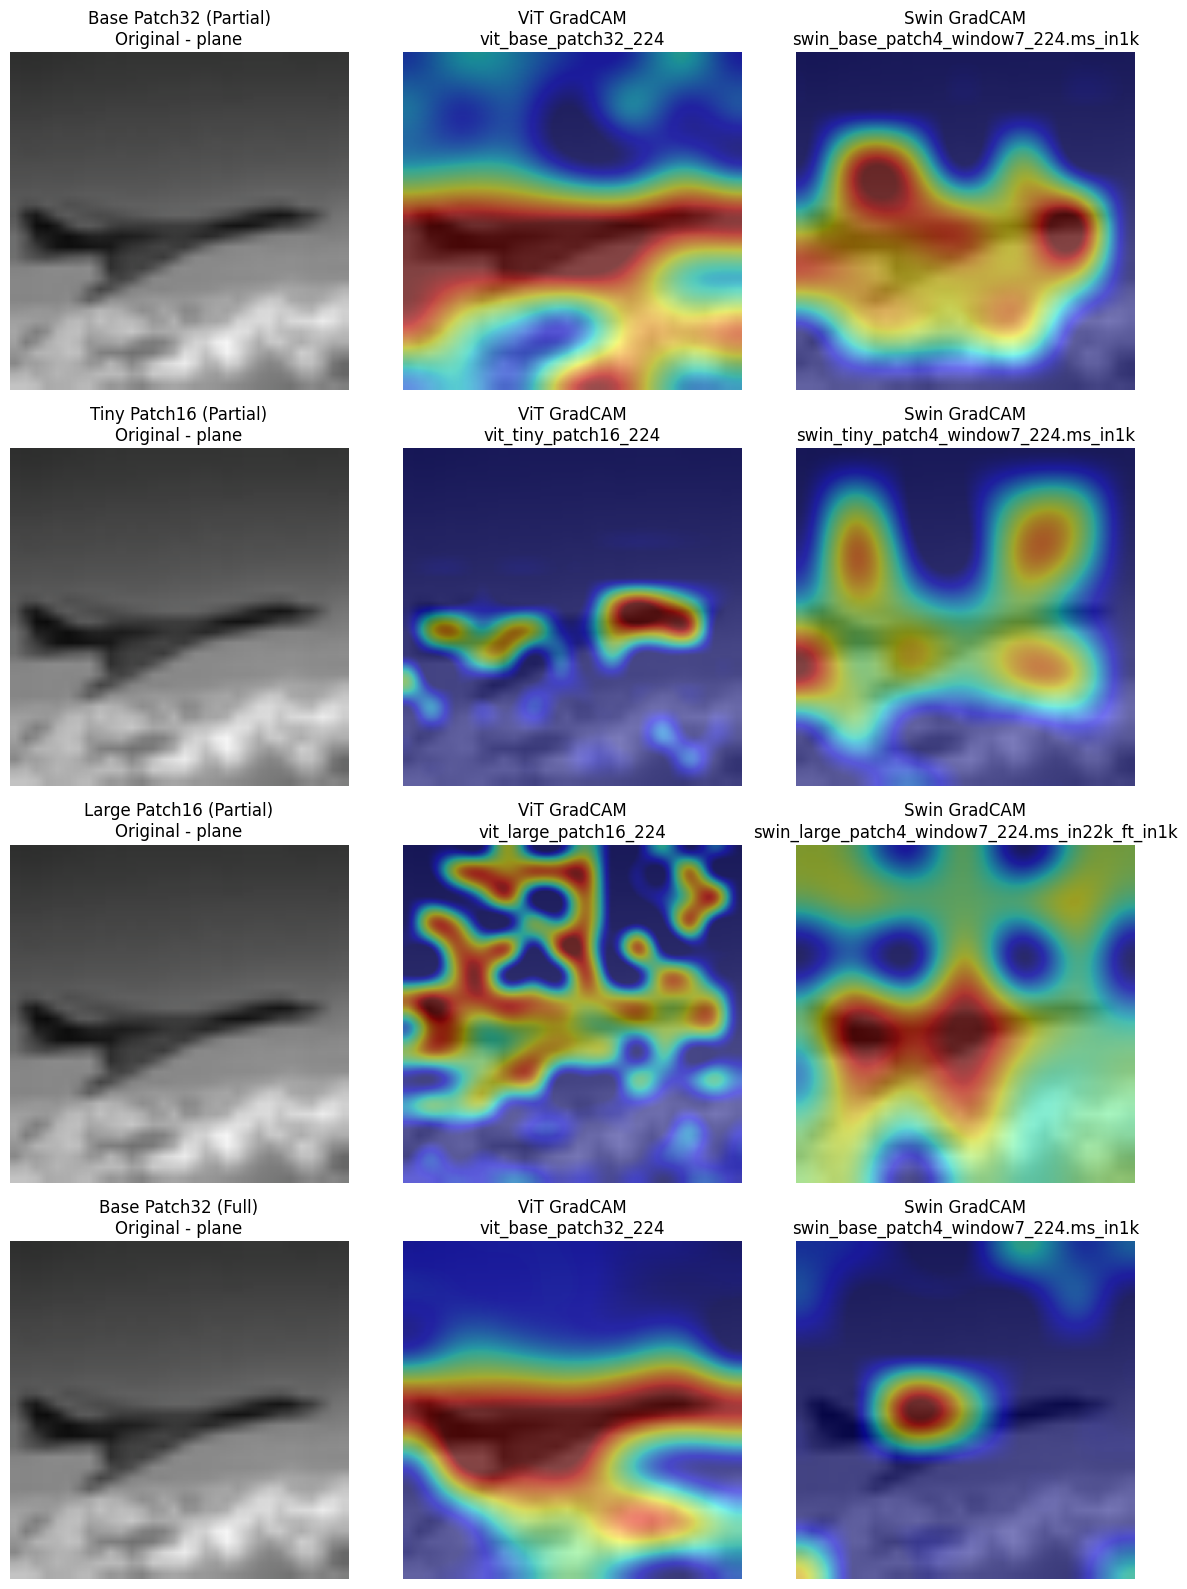


=== 圖片 2: ship ===
處理實驗 test_4...
處理實驗 test_5...
處理實驗 test_6...
處理實驗 test_7...


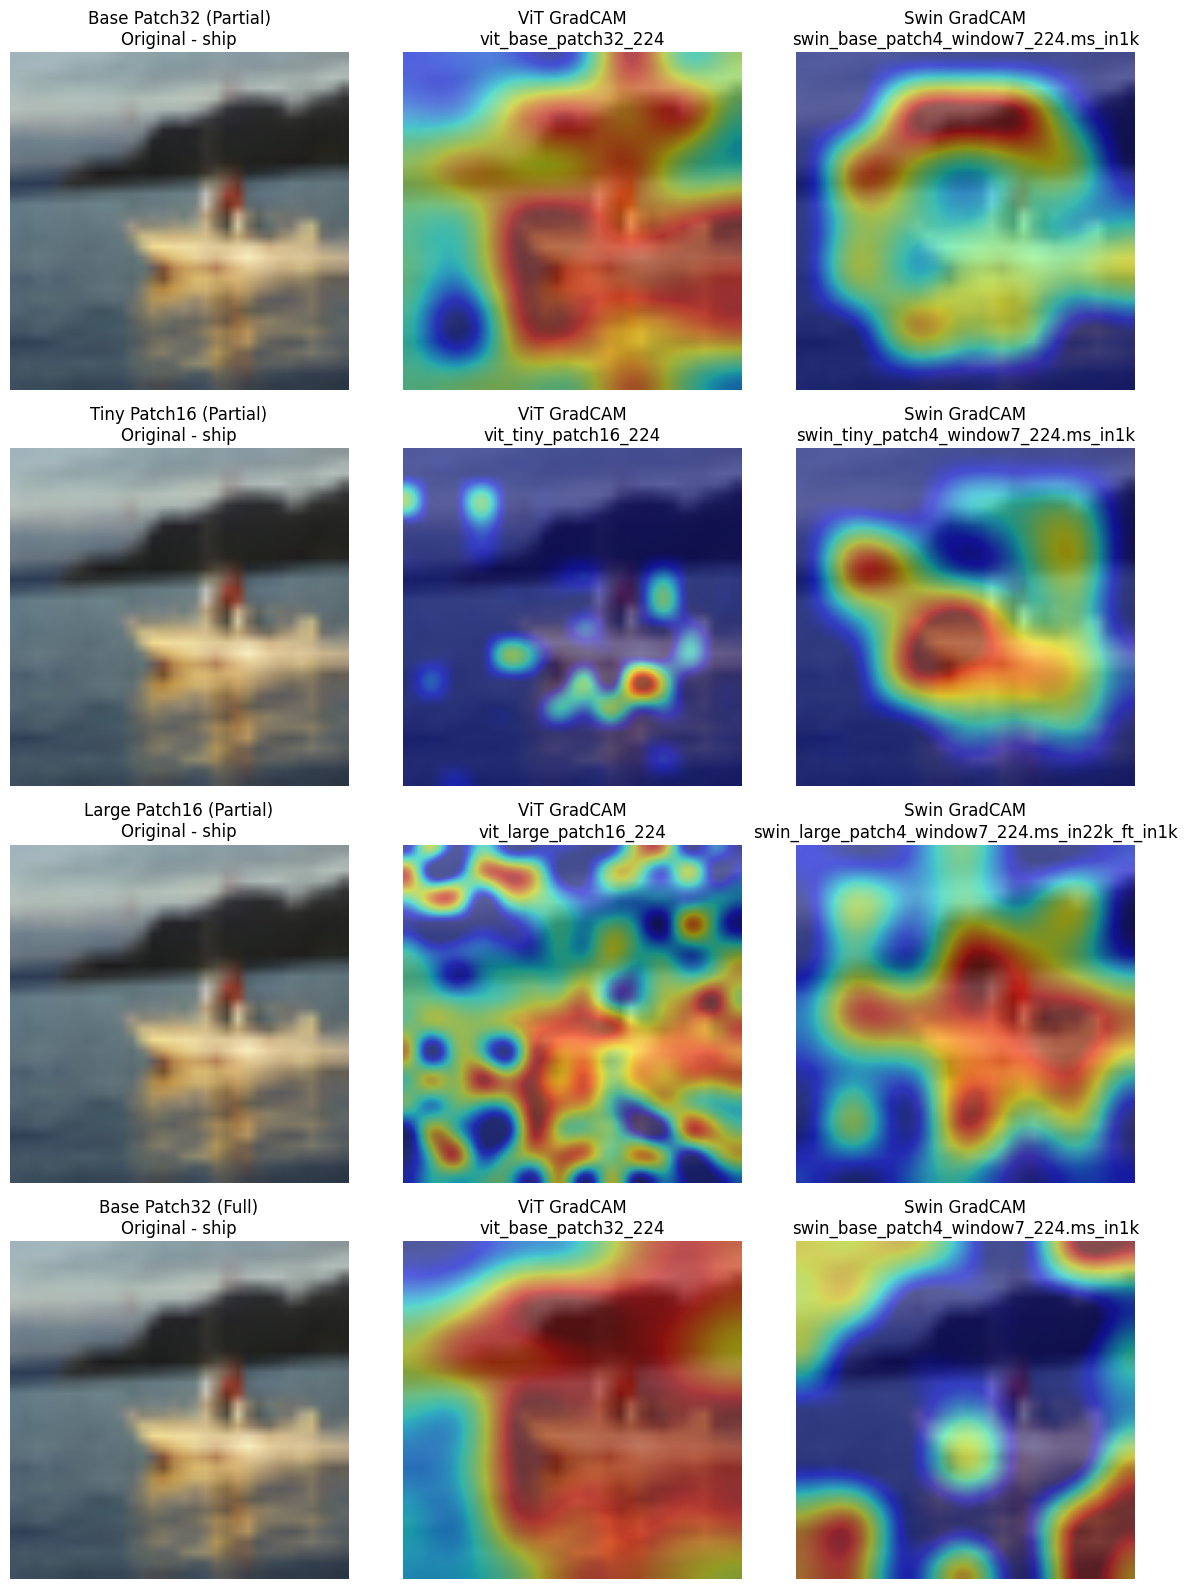


=== 圖片 3: plane ===
處理實驗 test_4...
處理實驗 test_5...
處理實驗 test_6...
處理實驗 test_7...


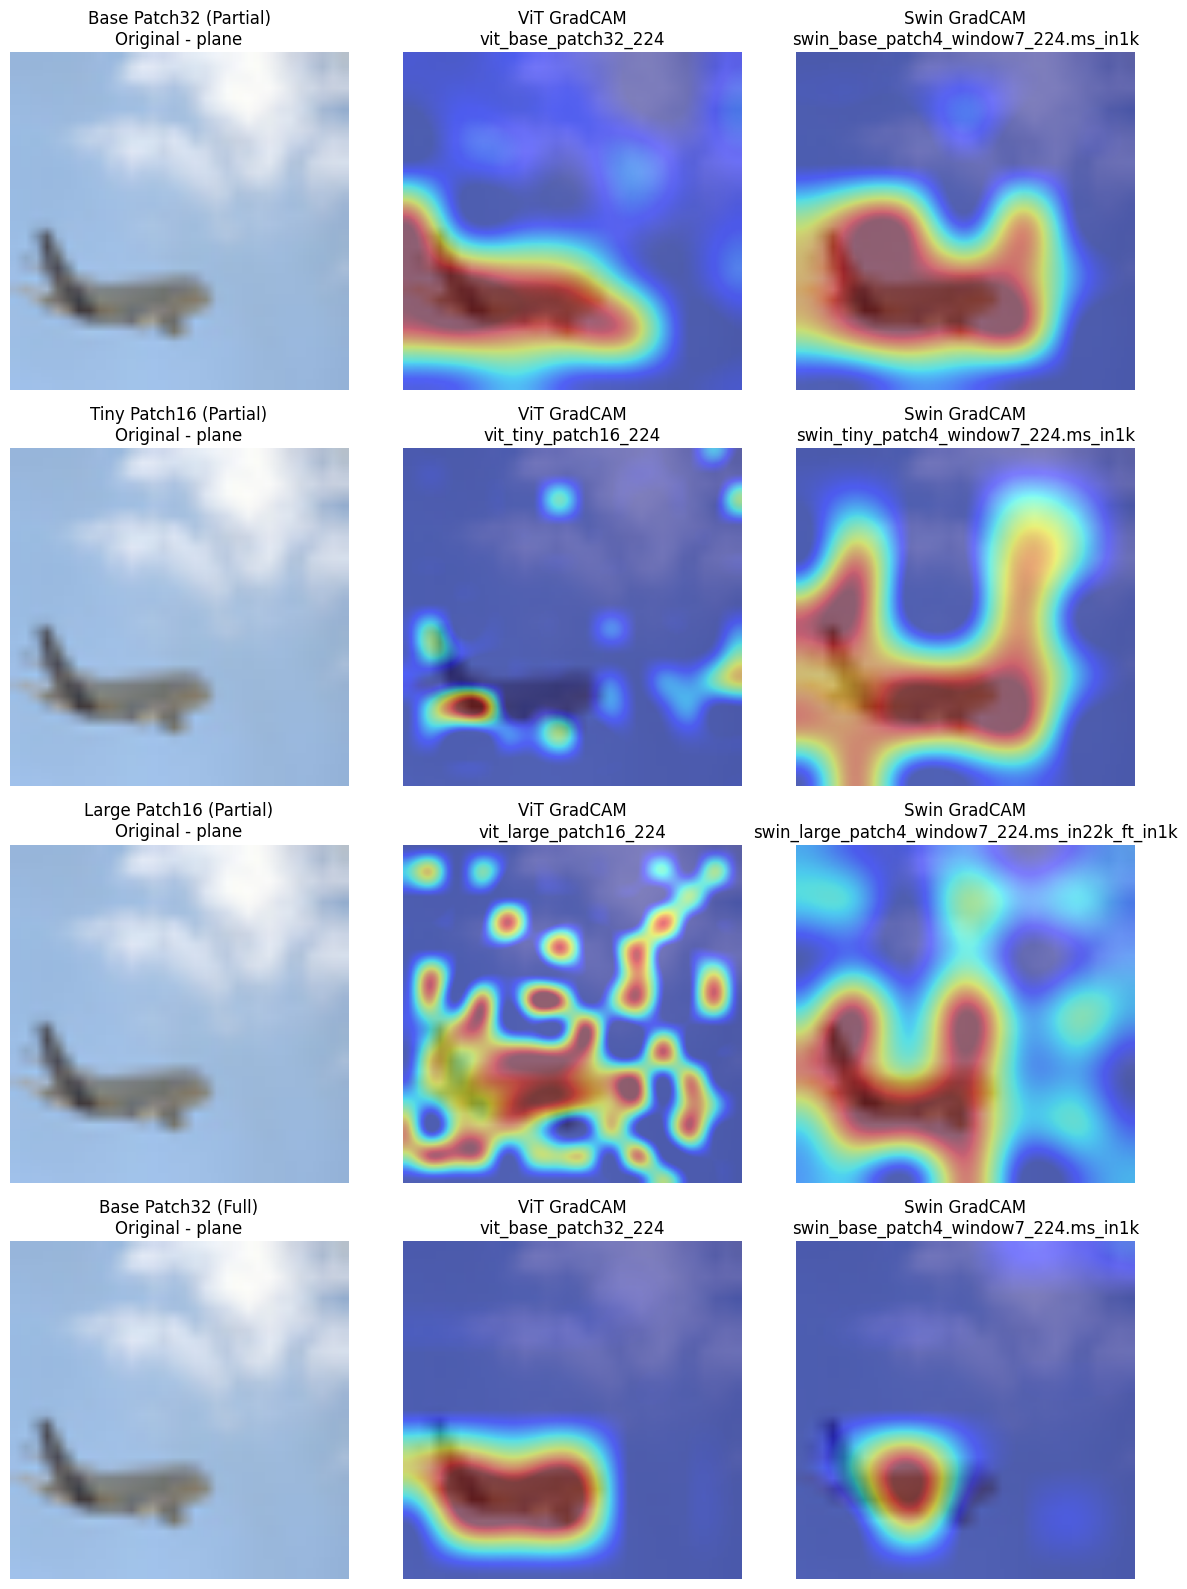


✅ 多實驗比較完成！


In [4]:
## 選擇要比較的實驗

print("\n🎯 可用的實驗:")
for i, (exp_name, exp_data) in enumerate(loaded_experiments.items()):
    print(f"{i+1}. {exp_name}: {exp_data['config']['name']}")

print(f"\n📊 將比較所有 {len(loaded_experiments)} 個實驗")
print("🖼️  生成比較可視化...")

# 生成多張圖片的比較（選擇前3張）
for img_idx in range(min(3, len(image_batch))):
    print(f"\n=== 圖片 {img_idx + 1}: {classes_name[label_batch[img_idx]]} ===")
    generate_comparison_visualization(loaded_experiments, image_batch, label_batch, img_idx)

print("\n✅ 多實驗比較完成！")